In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np 
import pandas as pd
from datasets import load_dataset

import matplotlib.pyplot as plt

In [3]:
%pip install --upgrade pyspark

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install --upgrade py4j

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-1.8'

In [6]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

from itertools import product

In [7]:
try:
    sc = SparkContext.getOrCreate()

    if sc:
        sc.stop()
except Exception as e:
    print(e)

conf = SparkConf().setAppName("Recommendation_with_ALS")
sc = SparkContext(conf=conf).getOrCreate()
spark = SparkSession(sparkContext=sc)

In [8]:
print(f'App Name : {sc.appName}')
print(f'Version : {sc.version}')
print(f"Spark User : {sc.sparkUser()}")

App Name : Recommendation_with_ALS
Version : 3.4.1
Spark User : 90530


In [9]:
sc

<SparkContext master=local[*] appName=Recommendation_with_ALS>

In [10]:
dataset = load_dataset("ashraq/movielens_ratings")  

df = dataset['train'].to_pandas()

Found cached dataset parquet (C:/Users/90530/.cache/huggingface/datasets/ashraq___parquet/ashraq--movielens_ratings-139b1d983e5c8861/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
df.head(3)

imdbId  tmdbId  movie_id  user_id  rating  \
0  tt2096673  150540      2307    11923     3.5   
1  tt5160928  393732      7157    32503     3.0   
2  tt3498820  271110      1398    20241     3.0   

                               title  \
0                  Inside Out (2015)   
1                 Mean Dreams (2017)   
2  Captain America: Civil War (2016)   

                                              genres  \
0  Adventure|Animation|Children|Comedy|Drama|Fantasy   
1                                           Thriller   
2                             Action|Sci-Fi|Thriller   

                                             posters  
0  https://m.media-amazon.com/images/M/MV5BOTgxMD...  
1  https://m.media-amazon.com/images/M/MV5BMDM2OD...  
2  https://m.media-amazon.com/images/M/MV5BMjQ0MT...

In [12]:
df_train = dataset['train'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres']]
df_val = dataset['validation'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres']]

In [13]:
df_train.head(3)

movie_id  user_id  rating  \
0      2307    11923     3.5   
1      7157    32503     3.0   
2      1398    20241     3.0   

                                              genres  
0  Adventure|Animation|Children|Comedy|Drama|Fantasy  
1                                           Thriller  
2                             Action|Sci-Fi|Thriller

In [14]:
df_train.to_csv("../Datas/df_train.csv", index=False)
df_val.to_csv('../Datas/df_val.csv', index=False)

In [15]:
df_rating_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')
df_rating_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')

genres_train = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select('genres') 
genres_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select('genres')

# concat_data = df_rating_train.union(df_rating_val).limit(10000)
concat_genres = genres_train.union(genres_val)
concat_data = df_rating_train.union(df_rating_val)

In [16]:
num_rows = concat_data.count()
num_uniq_movies = len(concat_data.select("movie_id").distinct().collect())

print(f"Number of rows : {num_rows}")
print(f"Number of movie : {num_uniq_movies}")

Number of rows : 990425
Number of movie : 15603


In [17]:
concat_data.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [18]:
concat_data.show(10)

+--------+-------+------+
|movie_id|user_id|rating|
+--------+-------+------+
|    2307|  11923|   3.5|
|    7157|  32503|   3.0|
|    1398|  20241|   3.0|
|    2625|  42975|   5.0|
|    8457|  31336|   3.0|
|    2230|  38922|   4.0|
|    5110|  41802|   3.5|
|     935|  36706|   3.5|
|     936|  21320|   5.0|
|    8960|   2930|   2.5|
+--------+-------+------+
only showing top 10 rows



In [19]:
concat_genres.take(3)

[Row(genres='Action|Adventure|Animation|Children|Comedy'),
 Row(genres='Drama|Sci-Fi|IMAX'),
 Row(genres='Drama|Fantasy')]

In [51]:
genres_count = concat_genres.rdd.flatMap(lambda genres: genres['genres'].split('|')) \
    .map(lambda g: (g, 1)) \
    .reduceByKey(lambda x, y: x + y)

from itertools import islice

for genres, count in islice(genres_count.collect(), 10):
    print(f"{genres}: {count}")

<Axes: >

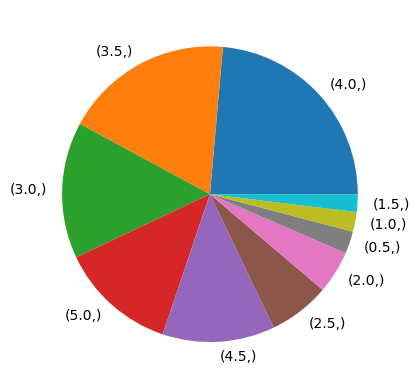

In [33]:
rating_list = [rating[0] for rating in concat_data.select("rating").collect()]
pd.DataFrame(rating_list).value_counts().plot(kind='pie')

Text(0, 0.5, 'Frequency')

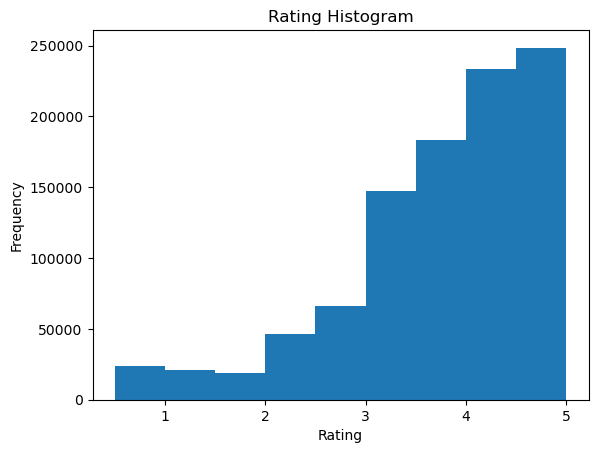

In [34]:
bin_edges = np.arange(0.5, 5.5, step=0.5)

plt.hist(
    rating_list, bins=bin_edges, histtype='bar'
)

plt.title("Rating Histogram")
plt.xlabel('Rating')    
plt.ylabel('Frequency')

In [35]:
indexer_movie = StringIndexer(inputCol='movie_id', outputCol='movie_index')
indexer_user = StringIndexer(inputCol='user_id', outputCol='user_index')    

In [36]:
pipeline = Pipeline(stages=[indexer_movie, indexer_user])

tf_df = pipeline.fit(concat_data).transform(concat_data)

tf_df.show(10)

+--------+-------+------+-----------+----------+
|movie_id|user_id|rating|movie_index|user_index|
+--------+-------+------+-----------+----------+
|    2307|  11923|   3.5|        3.0|    3546.0|
|    7157|  32503|   3.0|     3137.0|     587.0|
|    1398|  20241|   3.0|       20.0|    9092.0|
|    2625|  42975|   5.0|       78.0|    6216.0|
|    8457|  31336|   3.0|      303.0|     716.0|
|    2230|  38922|   4.0|        0.0|    2575.0|
|    5110|  41802|   3.5|       96.0|     362.0|
|     935|  36706|   3.5|       13.0|    1282.0|
|     936|  21320|   5.0|        8.0|   30282.0|
|    8960|   2930|   2.5|      105.0|     562.0|
+--------+-------+------+-----------+----------+
only showing top 10 rows



In [18]:
(train_data, test_data) = tf_df.randomSplit([0.9, 0.1], seed=5030)

print(f"train count : {train_data.count()}")
print(f"test count : {test_data.count()}")

train count : 891651
test count : 98774


In [20]:
models = []
df = pd.DataFrame(columns=['rank_', 'iteration', 'regParam_', 'model', 'predictions', 'rmse', 'mse'])

def als_model(rank_, iteration, regParam_):
        als = ALS(
                rank = rank_,
                maxIter = iteration,
                regParam = regParam_, 
                numUserBlocks = 10, # Default
                numItemBlocks = 10, # Default
                implicitPrefs = False, # Default
                alpha = 1.0, # Default
                userCol = 'user_id', # Default
                itemCol = 'movie_id', # Default
                seed = None, # Default
                ratingCol = 'rating', # Default
                nonnegative = False, # Default
                checkpointInterval = 10, # Default
                intermediateStorageLevel = 'MEMORY_AND_DISK', # Default
                finalStorageLevel = 'MEMORY_AND_DISK', # Default
                coldStartStrategy = 'nan', # Default
                blockSize = 4096, # Default
        )

        model = als.fit(train_data)
        model.setPredictionCol("predictions")
        predictions = model.transform(test_data)
        predictions = predictions.filter(predictions.predictions != float('nan'))

        evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="predictions")
        rmse=evaluator.evaluate(predictions)

        evaluator2=RegressionEvaluator(metricName="mse",labelCol="rating",predictionCol="predictions")
        mse=evaluator2.evaluate(predictions)

        models.append(model)
        df.loc[len(df)] = [rank_, iteration, regParam_, model, predictions, rmse, mse]

In [21]:
rank_params = [10, 50, 200]
iteration_params = [10, 20]
lambda_params = [0.1, 0.01]

for r, i, l in product(rank_params, iteration_params, lambda_params):
    als_model(r, i, l)
    print(f"model {len(df)} is done ")

model 1 is done 
model 2 is done 
model 3 is done 
model 4 is done 
model 5 is done 
model 6 is done 
model 7 is done 
model 8 is done 
model 9 is done 
model 10 is done 
model 11 is done 


Py4JJavaError: An error occurred while calling o2232.evaluate.
: org.apache.spark.SparkException: Job 212 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1212)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1210)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1210)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3011)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2902)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1509)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2902)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2128)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1509)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2128)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2081)
	at org.apache.spark.SparkContext.$anonfun$new$31(SparkContext.scala:664)
	at org.apache.spark.util.SparkShutdownHook.run(ShutdownHookManager.scala:214)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$2(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$runAll$1(ShutdownHookManager.scala:188)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.util.SparkShutdownHookManager.runAll(ShutdownHookManager.scala:188)
	at org.apache.spark.util.SparkShutdownHookManager$$anon$2.run(ShutdownHookManager.scala:178)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
df.groupby('mse').min().head()

rank_  iteration  regParam_  \
mse                                     
0.690159     10         20        0.1   
0.690764     50         20        0.1   
0.691836    200         20        0.1   
0.699129     10         10        0.1   
0.716072     50         10        0.1   

                                             model  \
mse                                                  
0.690159   ALSModel: uid=ALS_caf31b30a9cf, rank=10   
0.690764   ALSModel: uid=ALS_7dd9edac96e1, rank=50   
0.691836  ALSModel: uid=ALS_c0af2dfe74f9, rank=200   
0.699129   ALSModel: uid=ALS_89896d665241, rank=10   
0.716072   ALSModel: uid=ALS_77b51b0a74bb, rank=50   

                                                predictions      rmse  
mse                                                                    
0.690159  DataFrame[movie_id: int, user_id: int, rating:...  0.830758  
0.690764  DataFrame[movie_id: int, user_id: int, rating:...  0.831122  
0.691836  DataFrame[movie_id: int, user_id: int, rating:...  0.831767  
0.699129  DataFrame[movie_id: int, user_id: int, rating:...  0.836140  
0.716072  DataFrame[movie_id: int, user_id: int, rating:...  0.846210

In [ ]:
df.groupby('rmse').min().head()

rank_  iteration  regParam_  \
rmse                                    
0.830758     10         20        0.1   
0.831122     50         20        0.1   
0.831767    200         20        0.1   
0.836140     10         10        0.1   
0.846210     50         10        0.1   

                                             model  \
rmse                                                 
0.830758   ALSModel: uid=ALS_caf31b30a9cf, rank=10   
0.831122   ALSModel: uid=ALS_7dd9edac96e1, rank=50   
0.831767  ALSModel: uid=ALS_c0af2dfe74f9, rank=200   
0.836140   ALSModel: uid=ALS_89896d665241, rank=10   
0.846210   ALSModel: uid=ALS_77b51b0a74bb, rank=50   

                                                predictions       mse  
rmse                                                                   
0.830758  DataFrame[movie_id: int, user_id: int, rating:...  0.690159  
0.831122  DataFrame[movie_id: int, user_id: int, rating:...  0.690764  
0.831767  DataFrame[movie_id: int, user_id: int, rating:...  0.691836  
0.836140  DataFrame[movie_id: int, user_id: int, rating:...  0.699129  
0.846210  DataFrame[movie_id: int, user_id: int, rating:...  0.716072

In [ ]:
model_mse = [m for m in models if m == df.groupby('mse').min().iloc[0]['model']][0] 

model_rmse = [m for m in models if m == df.groupby('rmse').min().iloc[0]['model']][0]


if model_rmse == model_mse:
    model = model_rmse
    print("models are same")
else:
    print("models arenot same")

models are same


In [ ]:
df[df['model'] == model]

rank_  iteration  regParam_                                    model  \
2     10         20        0.1  ALSModel: uid=ALS_caf31b30a9cf, rank=10   

                                         predictions      rmse       mse  
2  DataFrame[movie_id: int, user_id: int, rating:...  0.830758  0.690159

In [ ]:
predictions = df[df['model'] == model]['predictions'].values[0]
predictions.take(10)

[Row(movie_id=86, user_id=471, rating=5.0, movie_index=67.0, user_index=3530.0, predictions=4.380673885345459),
 Row(movie_id=122, user_id=42834, rating=3.5, movie_index=215.0, user_index=111.0, predictions=2.864773750305176),
 Row(movie_id=158, user_id=30903, rating=2.0, movie_index=587.0, user_index=5130.0, predictions=3.072054624557495),
 Row(movie_id=161, user_id=23364, rating=4.0, movie_index=86.0, user_index=27768.0, predictions=3.9790656566619873),
 Row(movie_id=182, user_id=31983, rating=3.5, movie_index=120.0, user_index=418.0, predictions=3.7553906440734863),
 Row(movie_id=182, user_id=42834, rating=3.0, movie_index=120.0, user_index=111.0, predictions=3.075294017791748),
 Row(movie_id=213, user_id=43527, rating=3.5, movie_index=128.0, user_index=8343.0, predictions=2.6689207553863525),
 Row(movie_id=228, user_id=148, rating=4.0, movie_index=262.0, user_index=140.0, predictions=3.4358553886413574),
 Row(movie_id=231, user_id=148, rating=3.0, movie_index=108.0, user_index=140.

In [ ]:
from pyspark.sql.functions import col
test = model.recommendForAllUsers(10).filter(col('user_id')== 3).select("recommendations").collect()
for item in test[0][0]:
    print(item.rating)

6.248376846313477
6.206021785736084
6.082241058349609
5.799007415771484
5.753098487854004
5.7023186683654785
5.5785064697265625
5.552544116973877
5.527855396270752
5.525574684143066


In [ ]:
# 5 movies recommendation for user_id = 100
user_recs = model.recommendForAllUsers(numItems=5)
movie_recommendation = user_recs.where(user_recs.user_id == 100).select("recommendations.movie_id", "recommendations.rating").collect()

In [ ]:
movie_df = pd.DataFrame(columns=["userId", 'movieId', 'movieRating'])

movie_id = movie_recommendation[0][0]
movie_rating = movie_recommendation[0][1]

for id_, rating in zip(movie_id, movie_rating):
    movie_df.loc[len(movie_df)] = [5, id_, rating]

movie_df

userId  movieId  movieRating
0     5.0  14418.0     5.157757
1     5.0   9835.0     5.096902
2     5.0   1362.0     5.094255
3     5.0  12472.0     4.858741
4     5.0  14382.0     4.765639

In [ ]:
item_recs = model.recommendForAllItems(numUsers=5)
user_recommendation = item_recs.where(item_recs.movie_id == 100).select("recommendations.user_id", "recommendations.rating").collect()

In [ ]:
user_df = pd.DataFrame(columns=['movieId', 'userId', 'movieRating'])

user_id = user_recommendation[0][0]
movie_rating = user_recommendation[0][1]

for id_, rating in zip(user_id, movie_rating):
    user_df.loc[len(user_df)] = [100, id_, rating]

user_df

movieId   userId  movieRating
0    100.0  23856.0     6.120047
1    100.0  27834.0     6.074754
2    100.0   6238.0     5.904249
3    100.0  28312.0     5.868137
4    100.0  13173.0     5.789801